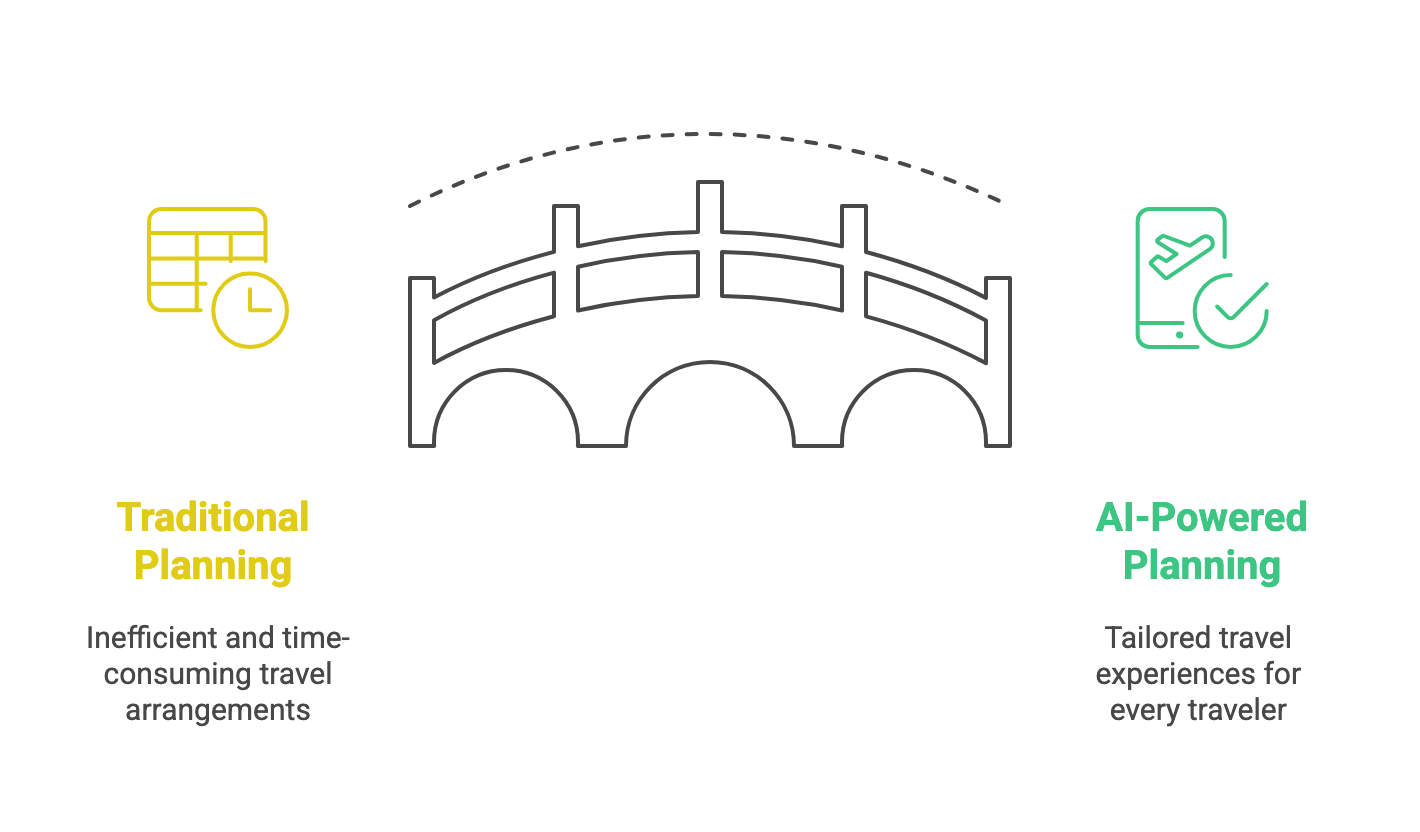

# Crafting an Intelligent Travel Planning Agent

## Introduction

This notebook demonstrates a **travel planning agent**, powered by the versatile capabilities of LangChain and LangGraph.

**Problem: The Complexity of Traditional Travel Planning**

*   **Fragmented Planning:** Travelers must check multiple sources for travel details, making planning inefficient and time-consuming.
*   **Generic Solutions:** Standard planning lacks personalization for individual needs and preferences.

**Solution: AI-Powered Personalized Travel Planning**

This project builds the foundation for a travel planning agent leveraging LangChain's tool integration and LangGraph's ability to orchestrate multi-step workflows, enabling:

*   **Intelligent Information Retrieval:** By utilizing tools like search engines and weather APIs, the agent can intelligently gather relevant and up-to-date travel information.
*   **Personalized Recommendation Generation:** The system aims to understand user preferences and constraints to provide tailored suggestions for flights, accommodations, and activities.

**Project Focus & Limitations**

This demonstration will showcase:

*   A travel planner using LangChain tools and custom tools.
*   LangGraph's intelligent tool coordination.
*   Short-term memory for context maintenance.

This demonstration will **not** cover:
*   Real-time booking integrations.
*   Complex travel scenarios (e.g., multi-city international trips with specific visa requirements).
*   Extensive LLM and tools evaluations.

Key components:
* **LLM:** Gemini 2.0 Flash
* **Tools:** TavilySearchResults, OpenWeatherMapAPIWrapper, custom tools
* **LangChain, LangGraph Framework:** Core frameworks for building the conversational agent
* **Prompt Engineering:** Structured prompts to guide the agent's responses


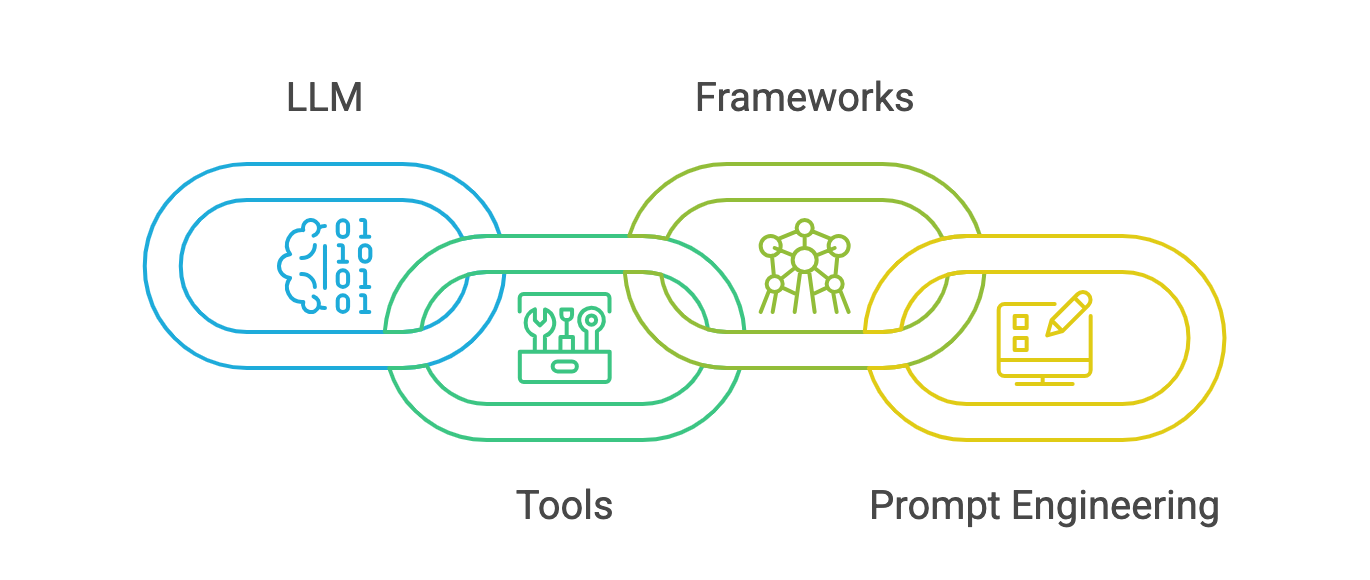

## Agent Workflow
The agent follows this workflow:

1. Extract trip parameters (destination, dates, preferences, budget) from user input
2. Use Tavily's Search API to find flight options
3. Use Tavily's Search API to find hotels matching preferences
4. Use OpenWeatherMap API to get destination weather
5. Use Tavily's Search API to find relevant activities
6. Use custom tool 'itinerary_builder' to assemble all information
7. Return a travel itinerary to user

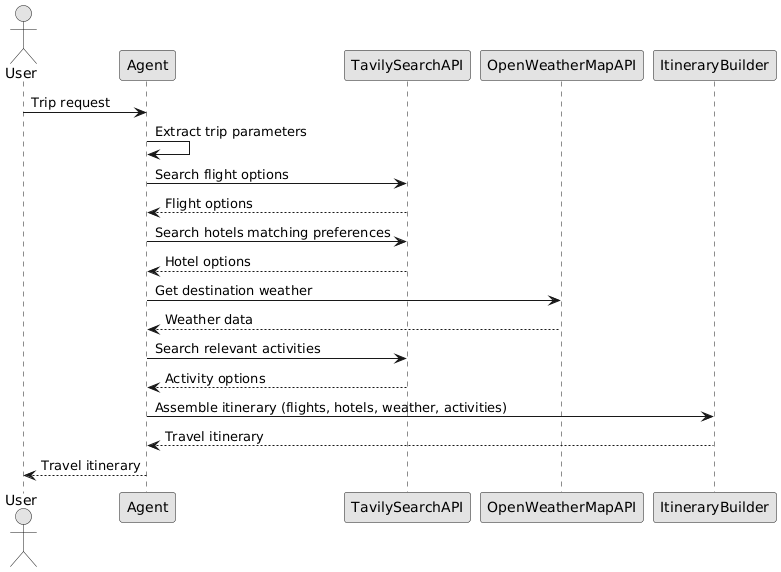


## Implementation Steps
### Setting Up the Environment

In [ ]:
# Load the environment variables
import os
from dotenv import load_dotenv

_ = load_dotenv()

In [ ]:
# Set up the LLM
from langchain_google_genai import ChatGoogleGenerativeAI

GEMINI_API_KEY = os.environ.get("GEMINI_API_KEY")
llm = ChatGoogleGenerativeAI(model="gemini-2.0-flash", api_key=GEMINI_API_KEY)

### Configuring the Tools
Next, we'll set up each tool our agent will use:

In [ ]:
# Configure Tavily Search API for travel information
from langchain_community.tools.tavily_search import TavilySearchResults

TAVILY_API_KEY = os.environ.get("TAVILY_API_KEY")
search_tool = TavilySearchResults(api_key=TAVILY_API_KEY, max_results=5)

In [ ]:
# Configure OpenWeatherMap API for destination weather
from langchain_community.utilities import OpenWeatherMapAPIWrapper

OPENWEATHERMAP_API_KEY = os.environ.get("OPENWEATHERMAP_API_KEY")
weather = OpenWeatherMapAPIWrapper(openweathermap_api_key=OPENWEATHERMAP_API_KEY)

In [ ]:
from langchain.tools import tool

@tool
def get_weather(location: str) -> str:
    """Get the current weather in a given location"""
    return weather.run(location)

In [ ]:
# Custom tool for building travel itineraries
def itinerary_builder(destination: str, start_date: str, end_date: str, 
                      flights: str, accommodations: str, activities: str, 
                      weather_info: str, budget_constraints: str = None) -> str:
    """
    Builds a comprehensive travel itinerary based on provided information.
    
    Args:
        destination: The travel destination
        start_date: Trip start date (YYYY-MM-DD)
        end_date: Trip end date (YYYY-MM-DD)
        flights: Flight information
        accommodations: Hotel/lodging information
        activities: List of activities/attractions
        weather_info: Weather forecast for the destination
        budget_constraints: Optional budget limitations
        
    Returns:
        A formatted travel itinerary
    """
    # Assemble the itinerary in a structured format
    itinerary = f"""
    # TRAVEL ITINERARY: {destination}
    
    **Dates:** {start_date} to {end_date}
    
    ## Travel Details
    {flights}
    
    ## Accommodations
    {accommodations}
    
    ## Weather Forecast
    {weather_info}
    
    ## Recommended Activities
    {activities}
    """
    
    if budget_constraints:
        itinerary += f"\n## Budget Considerations\n{budget_constraints}"
        
    return itinerary

### Configuring the Agent
Now we'll set up the agent:
* Binding the necessary tools
* Defining the criteria for stopping
* Crafting the system prompt
* Implementing the LLM invocation function
* Establishing the graph workflow

In [ ]:
# Import modules required for defining tool nodes
from langgraph.prebuilt import ToolNode

# List of tools
tools = [search_tool, get_weather, itinerary_builder]

# Pass the tools to the ToolNode()
tool_node = ToolNode(tools)

# Bind tools to the LLM
model_with_tools = llm.bind_tools(tools)

Key 'title' is not supported in schema, ignoring
Key 'title' is not supported in schema, ignoring
Key 'title' is not supported in schema, ignoring


In [ ]:
from langgraph.graph import MessagesState, START, END

# Use MessagesState to define the state of the function
def should_continue(state: MessagesState):
    
    # Get the last message from the state
    last_message = state["messages"][-1]
    
    # Check if the last message includes tool calls
    if last_message.tool_calls:
        return "tools"
    
    # End the conversation if no tool calls are present
    return END

In [ ]:
from langchain_core.messages import AIMessage, HumanMessage, SystemMessage

def call_model(state: MessagesState):
    messages = state["messages"]

    system_prompt = """
You are an expert travel planner assistant. Your goal is to help users plan their perfect trip.

Follow these steps when planning a trip:
1. Use the search tool to find flight options based on the user's origin, destination, and dates
2. Use the search tool to find accommodation options that match the user's preferences and budget
3. Use the weather tool to get weather information for the destination during the planned dates
4. Use the search tool to find activities and attractions at the destination.
5. Use the itinerary_builder tool to create a comprehensive travel plan

Remember the user's preferences and budget constraints throughout the conversation.
Avoid redundant searches and refine your queries based on previous search results.

Always provide thoughtful, personalized recommendations based on the information you gather.

When providing weather information:

*   Include the average temperature, any expected precipitation (rain, snow), humidity, and wind speed.
*   Provide a short, natural-language assessment of the weather conditions. For example:
    *   "The weather in Orlando in April is typically around 20°C with overcast clouds. This is generally pleasant weather for outdoor activities. However, there's a small chance of rain, so it's a good idea to pack an umbrella or raincoat."
    *   "The weather in Paris in October is cool, with average temperatures around 12°C. Expect some rain, so be sure to bring waterproof clothing and an umbrella. The fall colors should be beautiful, though!"
    *   "Tokyo in March can be chilly, with temperatures averaging 8°C. Pack layers and a light jacket. The cherry blossoms may start to bloom towards the end of the month, which would be a beautiful sight!"

When providing activity recommendations:
* Give a description of the activity
* Reasoning for why this activity would be good for user
"""

    # Add system prompt to the beginning of the messages if it's not already present
    if not messages or not isinstance(messages[0], SystemMessage):
        messages_with_system = [SystemMessage(system_prompt)] + messages
    else:
        messages_with_system = messages

    last_message = messages[-1]

    if isinstance(last_message, AIMessage) and last_message.tool_calls:
        return {"messages": [AIMessage(content=last_message.tool_calls[0]["response"])]}

    return {"messages": [model_with_tools.invoke(messages_with_system)]}

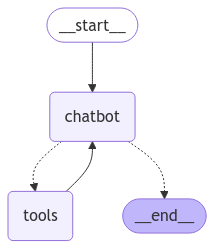

In [ ]:
from langgraph.graph import StateGraph
from langgraph.checkpoint.memory import MemorySaver
from IPython.display import Image, display

workflow = StateGraph(MessagesState)

# Add nodes for chatbot and tools
workflow.add_node("chatbot", call_model)
workflow.add_node("tools", tool_node)

# Define an edge connecting START to the chatbot
workflow.add_edge(START, "chatbot")

# Define conditional edges and route "tools" back to "chatbot"
workflow.add_conditional_edges("chatbot", should_continue, ["tools", END])
workflow.add_edge("tools", "chatbot")

# Set up memory and compile the workflow
memory = MemorySaver()
app = workflow.compile(checkpointer=memory)

display(Image(app.get_graph().draw_mermaid_png()))

In [ ]:
from langchain_core.messages import AIMessage, HumanMessage

config = {"configurable": {"thread_id": "1"}}

# Define the user agent function to stream through messages

def travel_agent(query):
    inputs = {"messages": [HumanMessage(content=query)]}
    
    # Stream messages and metadata from the chatbot application
    for msg, metadata in app.stream(inputs, config, stream_mode="messages"):
        
        # Check if the message has content and is not from a human
        if msg.content and not isinstance(msg, HumanMessage):
            print(msg.content, end="", flush=True)    
    print("\n")

### Testing the Agent
Finally, we'll test our agent with a sample travel planning request:

In [ ]:
# Test the travel planning agent
test_queries = [
    "I'm planning a family trip to Disney World in Orlando for 7 days in April 15. We have two kids ages 5 and 8. Our budget is $5000 total.",
    
    "I want to take a romantic weekend getaway to Paris in April. Looking for luxury hotels and fine dining recommendations. Budget is not a concern.",
    
    "I need to plan a business trip to Tokyo for 5 days in March. I'll need hotel recommendations near the financial district and information about transportation from the airport.",    
]

# Run the test queries
travel_agent(test_queries[0])


Okay, I can help you plan your family trip to Disney World! Let's start by gathering some essential information.

1.  **Flights:** I'll search for round-trip flights to Orlando for two adults and two children, arriving on April 15th and departing 7 days later.
2.  **Accommodation:** I'll look for family-friendly hotels in or near Disney World that can accommodate four people, keeping your budget in mind.
3.  **Weather:** I'll check the weather forecast for Orlando during your travel dates to help you pack accordingly.
4.  **Activities:** I'll research age-appropriate activities and attractions within Disney World that your 5 and 8-year-olds will enjoy.
5.  **Itinerary:** Finally, I'll create a detailed itinerary, including flights, accommodation, activities, and weather information, all while staying within your $5000 budget.

Let's start with the flights. Could you please provide your origin city so I can search for flights?



In [ ]:
travel_agent("I'll be flying from Saint Paul.")

[{"url": "https://www.google.com/travel/flights/flights-from-minneapolis-to-orlando.html", "content": "... Saint Paul International ... Orlando starts at $122 from Sun, Apr 6 to Tue, Apr 15. The cheapest one-way flight starts at $50 and departs on Tue, Apr 8."}, {"url": "https://www.expedia.com/lp/flights/msp/mco/minneapolis-to-orlando", "content": "Cheap Flights from Minneapolis (MSP) to Orlando (MCO) start at $59 for one-way and $117 for round trip. Earn your airline miles on top of our rewards!"}, {"url": "https://www.kayak.com/flight-routes/Minneapolis-St-Paul-MSP/Orlando-ORL", "content": "Find flights to Orlando from $48. Fly from Minneapolis on Spirit Airlines, Frontier, Sun Country Air and more. Search for Orlando flights on KAYAK now to"}, {"url": "https://www.travelocity.com/lp/flights/msp/mco/minneapolis-st-paul-intl-to-orlando-intl", "content": "Search for cheap flights deals from MSP to MCO (Minneapolis - St. Paul Intl. to Orlando Intl.). We offer cheap direct, non-stop fli

In [ ]:
travel_agent("I aslo want to bring a dog. The rest seems good.")

Okay, I will search for dog friendly hotels.[{"url": "https://www.booking.com/pets/region/us/disneyorlando.html", "content": "9,903 pet-friendly hotels ; Hyatt House Orlando Airport · From $143 per night · 1,094 reviews ; Drury Plaza Hotel Orlando - Disney Springs Area · From $144.49 per"}, {"url": "https://www.tripadvisor.com/HotelsList-Orlando-Pets-Allowed-Cheap-Hotels-zfp13535287.html", "content": "1. Drury Plaza Hotel Orlando - Disney Springs Area."}, {"url": "https://www.bringfido.com/lodging/city/disney-world-fl-us/", "content": "Red Roof Inn Orlando South Florida Mall allows 1 pet up to 80 lbs for no additional fee, and 2 pets up to 80 lbs for $15 per night (not to exceed $105 per stay"}, {"url": "https://www.visitorlando.com/blog/post/pet-friendly-hotels-orlando/", "content": "Two canine pets per room with a combined total weight of 40 pounds or less are welcome at Waldorf Astoria Orlando and Signia by Hilton Orlando"}, {"url": "https://www.kayak.com/Orlando-Hotels_Pet-Friendly

## Conclusion

In this notebook, we've built a conversational travel planning agent using LangChain that demonstrates several key capabilities:

1. **Contextual Understanding**: The agent can maintain context across multiple interactions, allowing users to refine their travel plans incrementally.

2. **Flexible Planning**: As shown in our examples, the agent can handle various travel requirements and modifications (like adding a pet to travel plans) while maintaining the core itinerary.

3. **Structured Output**: By using tools and structured prompting, our agent produces consistent, well-formatted travel plans that are easy to read and modify.

4. **Chain of Thought Reasoning**: The agent demonstrates how LLMs can be guided through a reasoning process to produce better results than simple prompt-response patterns.

This implementation showcases how LangChain can be used to create specialized agents that handle domain-specific tasks with a conversational interface. The travel agent could be further enhanced with:

- Integration with real travel APIs for live pricing and availability
- More specialized tools for different aspects of travel planning (accommodation, transportation, activities)
- Improved memory mechanisms to handle longer planning sessions
- User preference profiles to personalize recommendations

The patterns demonstrated here can be applied to many other domains where conversational AI can assist with complex planning or decision-making processes.